<a href="https://colab.research.google.com/github/sherry-ml/EVA7/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install the ViT PyTorch package and Linformer 

!pip install vit-pytorch linformer

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
# loading Libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
# import Linformer

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function
# import torch and related libraries 

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

In [ ]:
#to unzip the datasets
import zipfile   
#sklearn to split the data

from sklearn.model_selection import train_test_split

In [ ]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load data

os.makedirs('/data', exist_ok=True)
train_dir = 'data/train/'
test_dir = 'data/test/'


In [ ]:
%cp /content/drive/MyDrive/EVA7/VitDataset/train.zip /data/
%cp /content/drive/MyDrive/EVA7/VitDataset/test.zip /data/

In [ ]:
cd /data

/data


In [ ]:
#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')

In [ ]:
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

In [ ]:
ls /data/data/train

cat.0.jpg      cat.3250.jpg  cat.7751.jpg   dog.12250.jpg  dog.5500.jpg
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.55

In [ ]:
#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [ ]:
len(train_list) , len(test_list)

(25000, 12500)

In [ ]:
#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

In [ ]:
set(labels)

{'cat', 'dog'}

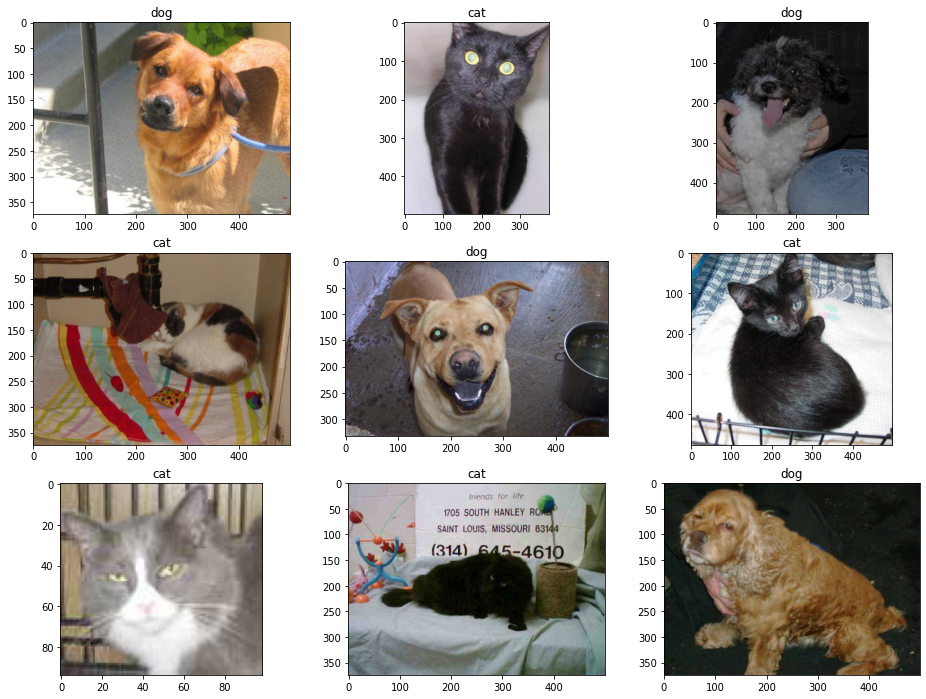

In [ ]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


In [ ]:
#Splitting train and validation list
seed=42
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [ ]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [ ]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [ ]:
#defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [ ]:
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
#Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
device='cuda'

In [ ]:
#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6953 - acc: 0.5009 - val_loss : 0.6931 - val_acc: 0.5075



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6915 - acc: 0.5250 - val_loss : 0.6881 - val_acc: 0.5291



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6858 - acc: 0.5470 - val_loss : 0.6816 - val_acc: 0.5706



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6772 - acc: 0.5742 - val_loss : 0.6716 - val_acc: 0.5878



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6689 - acc: 0.5905 - val_loss : 0.6605 - val_acc: 0.5967



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6607 - acc: 0.5946 - val_loss : 0.6538 - val_acc: 0.6027



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6516 - acc: 0.6083 - val_loss : 0.6400 - val_acc: 0.6232



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6412 - acc: 0.6203 - val_loss : 0.6353 - val_acc: 0.6311



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6373 - acc: 0.6261 - val_loss : 0.6340 - val_acc: 0.6272



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6307 - acc: 0.6379 - val_loss : 0.6352 - val_acc: 0.6254



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6231 - acc: 0.6472 - val_loss : 0.6225 - val_acc: 0.6396



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6188 - acc: 0.6486 - val_loss : 0.6108 - val_acc: 0.6531



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6132 - acc: 0.6530 - val_loss : 0.6129 - val_acc: 0.6574



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6116 - acc: 0.6561 - val_loss : 0.6047 - val_acc: 0.6614



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6047 - acc: 0.6622 - val_loss : 0.6022 - val_acc: 0.6630



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5993 - acc: 0.6708 - val_loss : 0.6065 - val_acc: 0.6669



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6002 - acc: 0.6685 - val_loss : 0.6009 - val_acc: 0.6622



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5952 - acc: 0.6706 - val_loss : 0.5957 - val_acc: 0.6778



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5914 - acc: 0.6785 - val_loss : 0.5901 - val_acc: 0.6683



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5928 - acc: 0.6747 - val_loss : 0.5827 - val_acc: 0.6830

